# Load libraries

In [1]:
import os
import warnings

from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import torch
from torch import nn
import h5py
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
warnings.filterwarnings("ignore")

# Read Data

In [2]:
DATA_FOLDER = "./data"


all_paths = [
    os.path.join(path, file) for path, _, files in os.walk(top=DATA_FOLDER) for file in files if ('.labels' in file) or ('.txt' in file)
]

label_names = {0: 'unlabeled', 
               1: 'man-made terrain', 
               2: 'natural terrain', 
               3: 'high vegetation', 
               4: 'low vegetation', 
               5: 'buildings', 
               6: 'hard scape', 
               7: 'scanning artefacts', 
               8: 'cars'}

In [3]:
all_files_df = pd.DataFrame({'path': all_paths})
all_files_df['basename'] = all_files_df['path'].map(os.path.basename)
all_files_df['id'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[0])
all_files_df['ext'] = all_files_df['basename'].map(lambda x: os.path.splitext(x)[1][1:])
all_files_df.sample(3)

path  \
2   ./data/sem8_labels_training/sem8_labels_traini...   
4   ./data/sem8_labels_training/sem8_labels_traini...   
14  ./data/sem8_labels_training/sem8_labels_traini...   

                                             basename  \
2                  sg28_station4_intensity_rgb.labels   
4   untermaederbrunnen_station3_xyz_intensity_rgb....   
14        bildstein_station3_xyz_intensity_rgb.labels   

                                               id     ext  
2                     sg28_station4_intensity_rgb  labels  
4   untermaederbrunnen_station3_xyz_intensity_rgb  labels  
14           bildstein_station3_xyz_intensity_rgb  labels

In [4]:
all_training_pairs = all_files_df.pivot_table(values = 'path', 
                                              columns = 'ext', 
                                              index = ['id'], 
                                              aggfunc = 'first').reset_index().dropna()
all_training_pairs

ext                                      id  \
0      bildstein_station1_xyz_intensity_rgb   
3    domfountain_station1_xyz_intensity_rgb   

ext                                             labels  \
0    ./data/sem8_labels_training/sem8_labels_traini...   
3    ./data/sem8_labels_training/sem8_labels_traini...   

ext                                                txt  
0    ./data/bildstein_station1_xyz_intensity_rgb/bi...  
3    ./data/domfountain_station1_xyz_intensity_rgb/...

In [5]:
_, test_row = next(all_training_pairs.dropna().tail(1).iterrows())
print(test_row)
read_label_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['class'], index_col = False)
read_xyz_data = lambda path, rows: pd.read_table(path, sep = ' ', nrows = rows, names = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b'], header = None) #x, y, z, intensity, r, g, b
read_joint_data = lambda c_row, rows: pd.concat([read_xyz_data(c_row['txt'], rows), read_label_data(c_row['labels'], rows)], axis = 1)
read_joint_data(test_row, 10)

ext
id                   domfountain_station1_xyz_intensity_rgb
labels    ./data/sem8_labels_training/sem8_labels_traini...
txt       ./data/domfountain_station1_xyz_intensity_rgb/...
Name: 3, dtype: object


x       y      z  intensity    r    g    b  class
0 -22.586 -72.368  0.640      -1365  227  226  231      0
1 -22.580 -72.500 -0.009      -1353   82   87  107      0
2 -22.603 -72.498 -0.030      -1367   96  108  134      0
3 -22.511 -72.496 -0.050      -1349   85   82   91      0
4 -22.512 -72.499 -0.037      -1368   83   80   89      0
5 -23.377 -78.032 -0.104      -1543   73   76   85      0
6 -22.535 -72.499 -0.058      -1344   85   84   92      0
7 -22.556 -72.495 -0.053      -1337   80   79   93      0
8 -22.535 -72.497 -0.036      -1367   84   81   90      0
9 -22.721 -72.514 -0.766      -1473   88   80   93      0

In [6]:
df = read_joint_data(test_row, None)
df.shape

(44990641, 8)

In [7]:
le = LabelEncoder()

df["class"] = le.fit_transform(df["class"])
sorted(df["class"].unique())

[0, 1, 2, 3, 4, 5, 6, 7]

# EDA

In [8]:
fraction = 0.1
sample = df.sample(frac=fraction)

CPU times: user 682 ms, sys: 238 ms, total: 920 ms
Wall time: 921 ms
Error in callback <function _draw_all_if_interactive at 0x7f5e26f2f910> (for post_execute):


KeyboardInterrupt: 

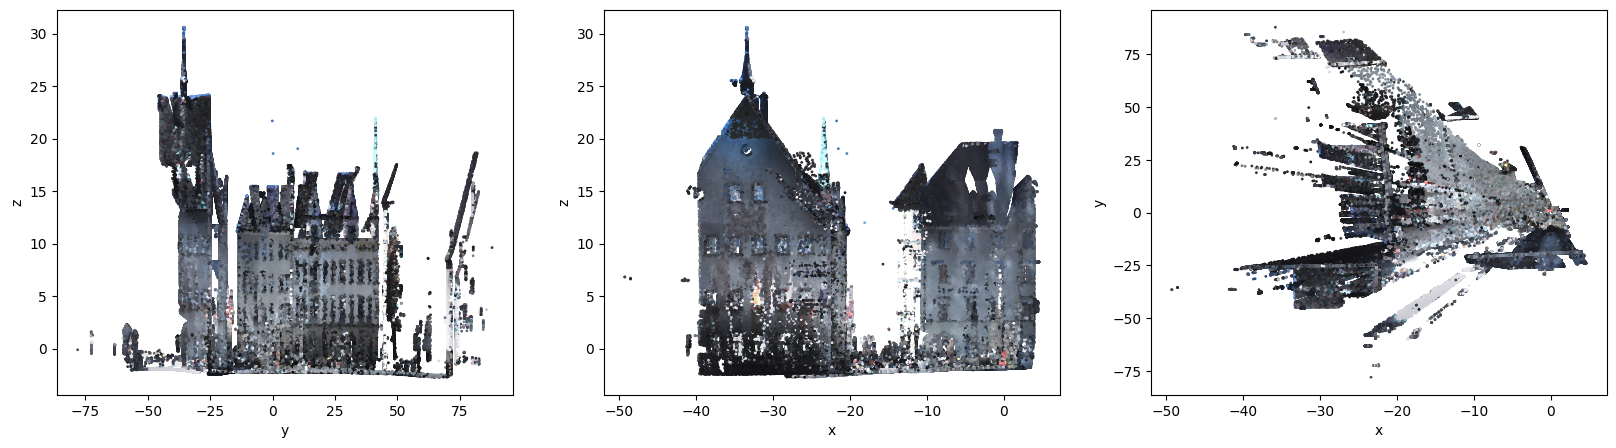

In [10]:
%%time
fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'
for i, c_ax in enumerate(m_axs.flatten()):
    plot_axes = [x for j, x in enumerate(ax_names) if j!=i]
    c_ax.scatter(sample[plot_axes[0]],
                sample[plot_axes[1]],
                c=sample[['r', 'g', 'b']].values / 255, 
                 s=1
                )
    c_ax.set_xlabel(plot_axes[0])
    c_ax.set_ylabel(plot_axes[1])

CPU times: user 1.15 s, sys: 213 ms, total: 1.37 s
Wall time: 1.36 s


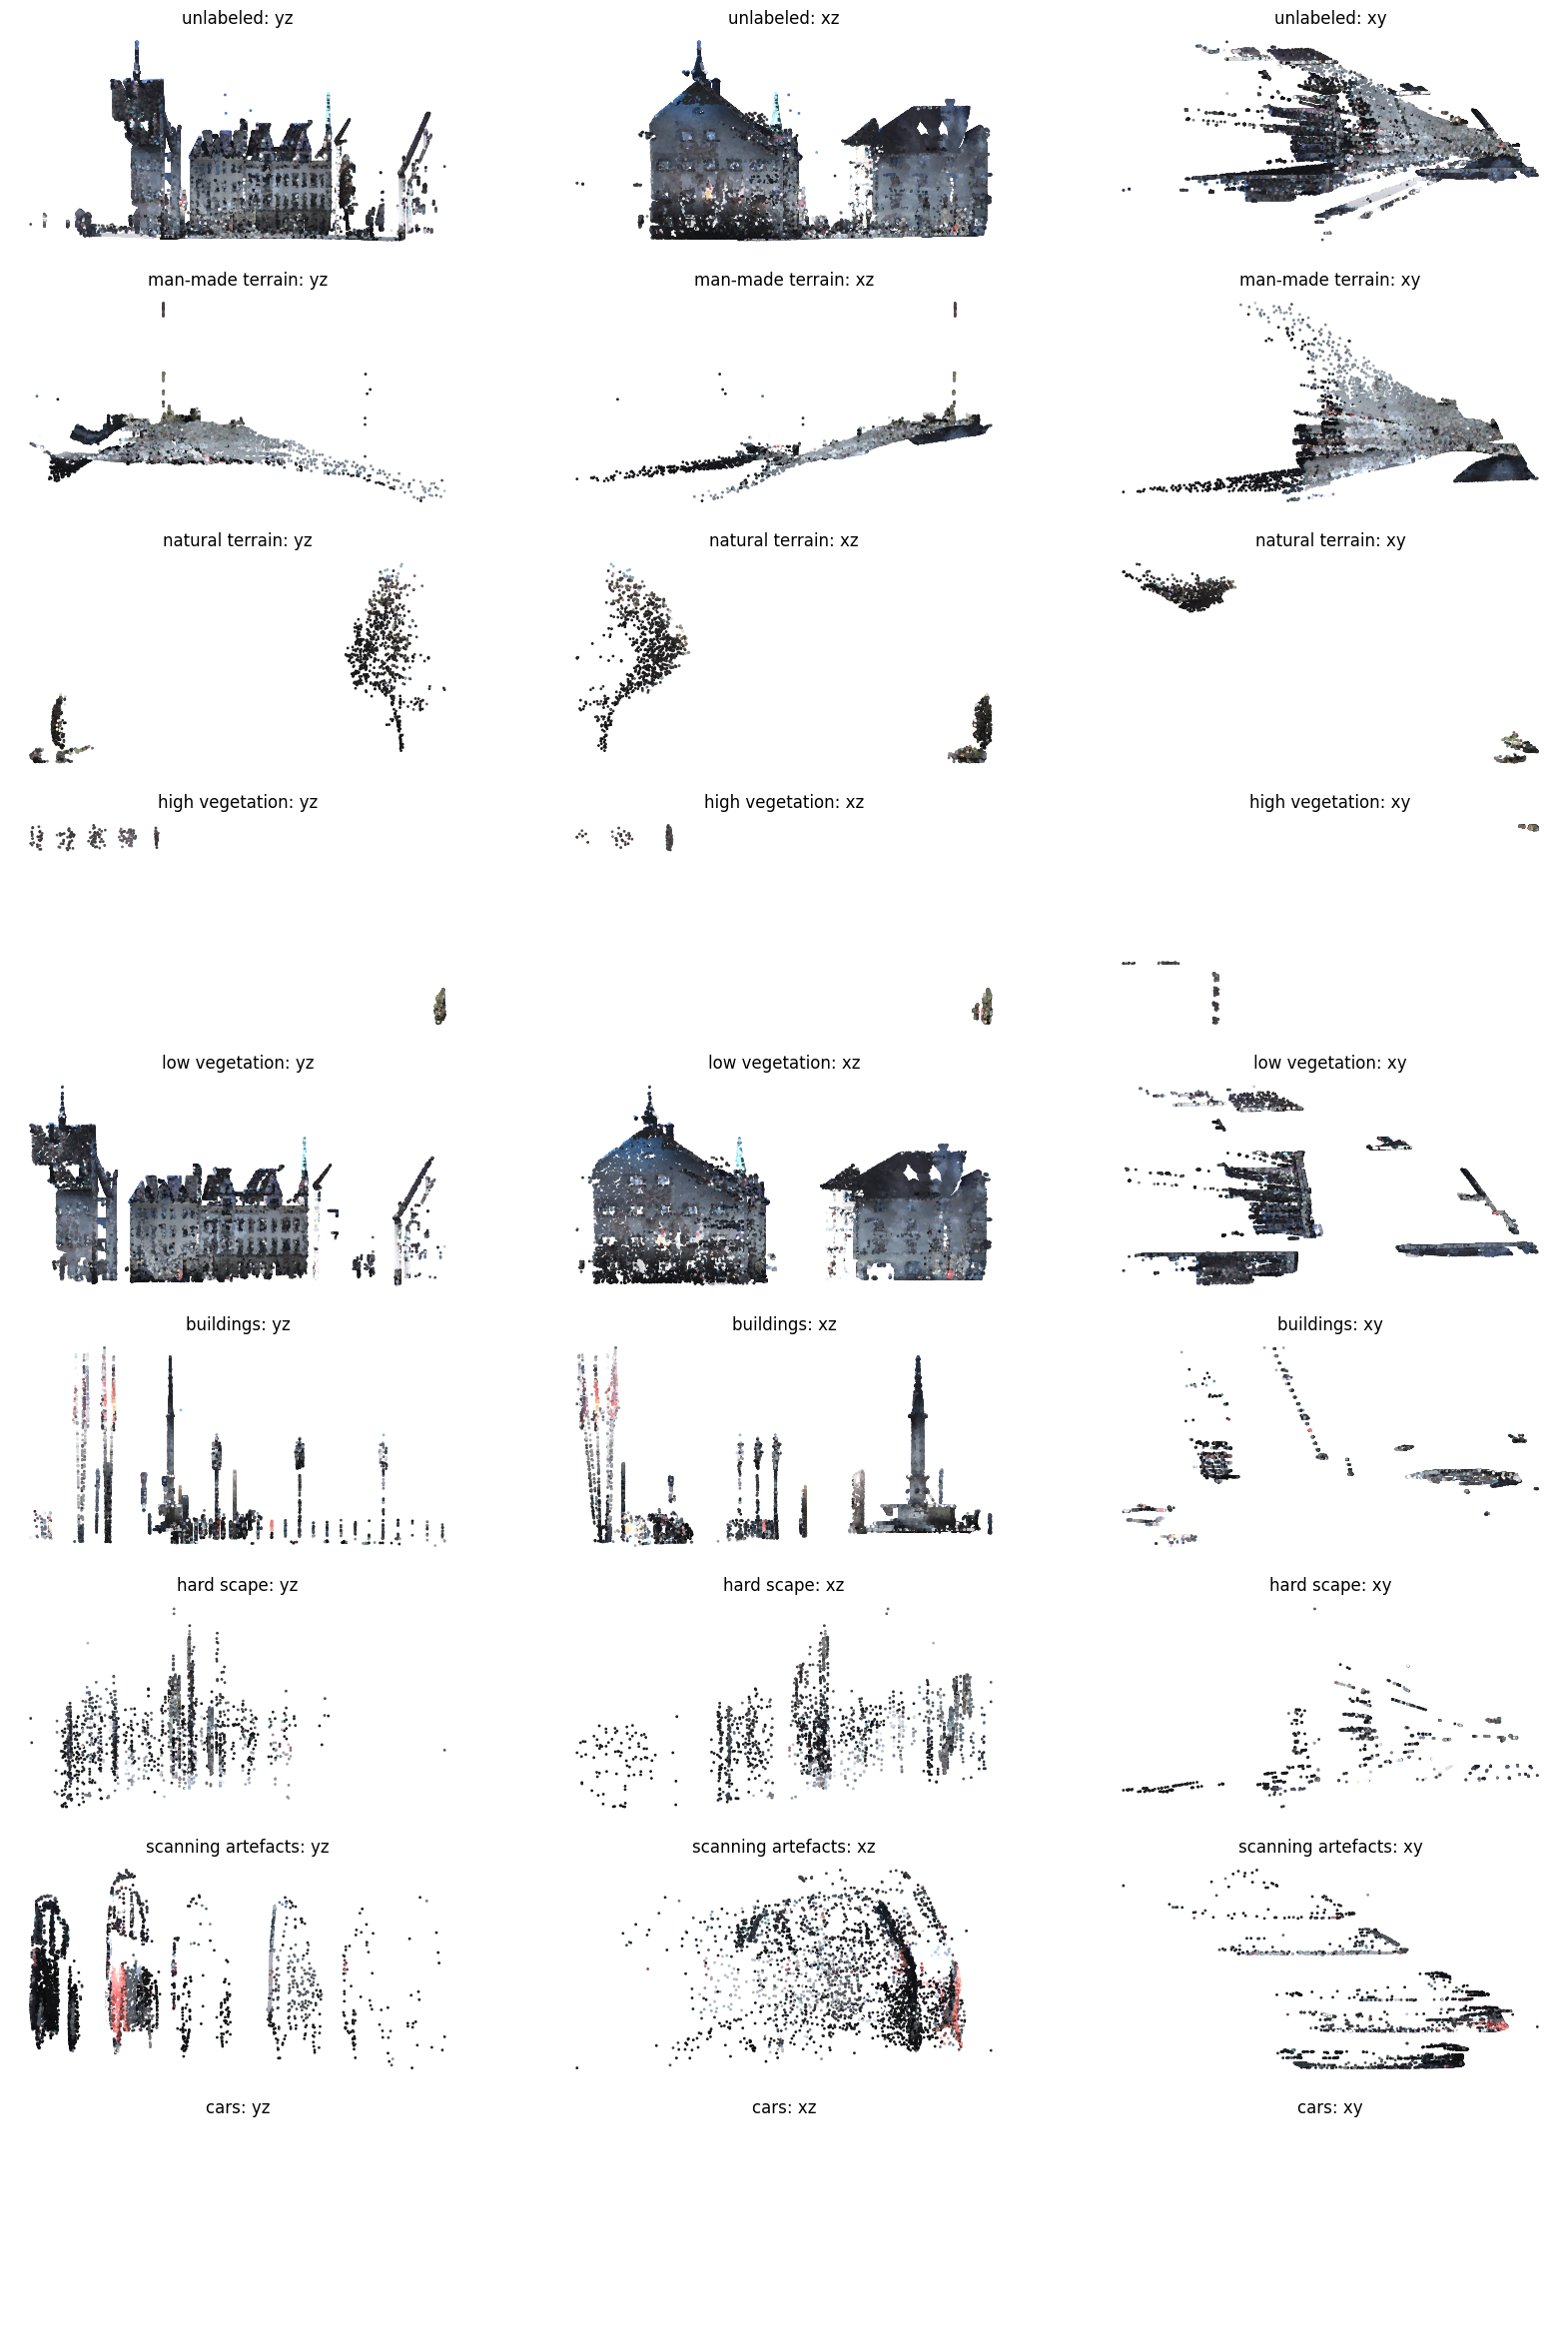

In [12]:
%%time
# fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'

max_keys = max(label_names.keys())
fig, m_axs = plt.subplots(max_keys + 1, 3, figsize = (20, 30))
for i, c_axs in enumerate(m_axs.T):
    plot_axes = [x for j, x in enumerate(ax_names) if j != i]
    for c_ax, (c_key, c_value) in zip(c_axs, label_names.items()):
        c_df = sample[sample['class'] == c_key]
        # print(c_df)
        c_ax.scatter(c_df[plot_axes[0]].values,
                  c_df[plot_axes[1]].values,
                  # '.', 
                  c=c_df[["r", "g", "b"]].values / 255,
                  label = c_value,
                  s=1
                 )
        c_ax.set_title('{}: {}'.format(c_value, ''.join(plot_axes)))
        c_ax.set_xlabel(plot_axes[0])
        c_ax.set_ylabel(plot_axes[1])
        c_ax.axis('off')

# Clean data

/tmp/ipykernel_17882/834474999.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/tmp/ipykernel_17882/834474999.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/tmp/ipykernel_17882/834474999.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

<Axes: xlabel='z'>

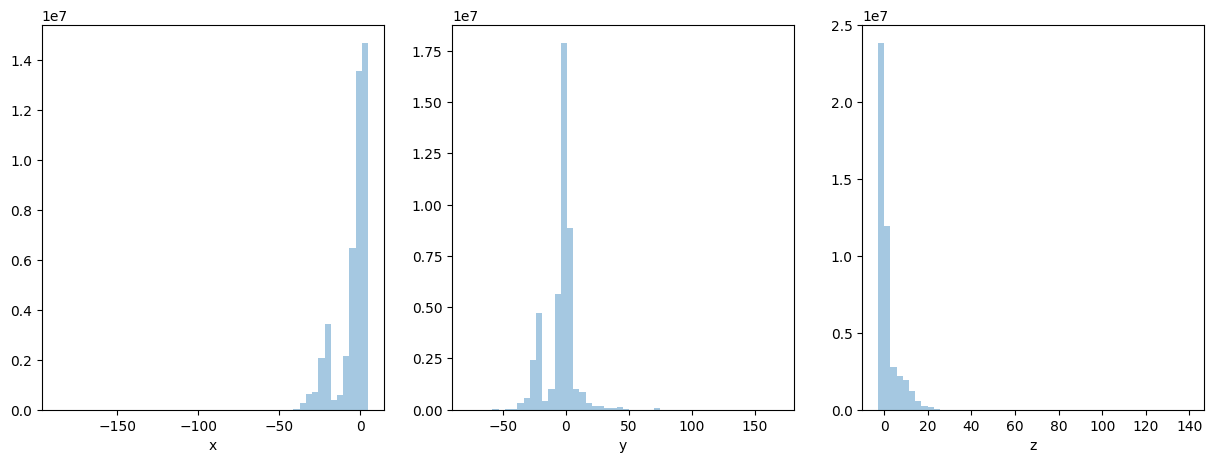

In [7]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
sns.distplot(df["x"], ax=axs[0], kde=False)
sns.distplot(df["y"], ax=axs[1], kde=False)
sns.distplot(df["z"], ax=axs[2], kde=False)

In [7]:
df = df.dropna()
df.shape

(44990641, 8)

# KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [11]:
scaler = StandardScaler()

model = KNeighborsClassifier(
    n_neighbors=5,
    algorithm="kd_tree"
)

In [12]:
features = ['x', 'y', 'z', 'intensity', 'r', 'g', 'b']

X, y = df[features], df["class"]

In [ ]:
N_SPLITS=6
RANDOM_STATE=42
SHUFFLE=True

scores = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=SHUFFLE)

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline = Pipeline(steps=[
        ('preprocess', scaler),
        ('classifier', model)
    ])        
    
    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_val)

    score = {
        "Balanced Accuracy": balanced_accuracy_score(y_val, preds),
        "Accuracy": accuracy_score(y_val, preds),
        "F1 Weighted": f1_score(y_val, preds, average='weighted'),
    }
    print(score)
    
    scores.append(score)

# CatBoost

In [17]:
from catboost import CatBoostClassifier

In [19]:
N_SPLITS=6
RANDOM_STATE=42
SHUFFLE=True

scores = []

skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=SHUFFLE)

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(
        verbose=100,
        task_type="GPU",
        random_state=42
    )
    
    model.fit(
        X_train, 
        y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100
    )

    preds = model.predict(X_val)

    score = {
        "Balanced Accuracy": balanced_accuracy_score(y_val, preds),
        "Accuracy": accuracy_score(y_val, preds),
        "F1 Weighted": f1_score(y_val, preds, average='weighted'),
    }
    print(score)
    
    scores.append(score)

Learning rate set to 0.304649
0:	learn: 1.0686223	test: 1.0686651	best: 1.0686651 (0)	total: 142ms	remaining: 2m 21s
10:	learn: 0.5553531	test: 0.5552773	best: 0.5552773 (10)	total: 1.51s	remaining: 2m 15s
20:	learn: 0.5328670	test: 0.5328798	best: 0.5328798 (20)	total: 2.93s	remaining: 2m 16s
30:	learn: 0.5280343	test: 0.5280498	best: 0.5280498 (30)	total: 4.32s	remaining: 2m 15s
40:	learn: 1.7374387	test: 1.7278421	best: 0.5267198 (36)	total: 5.73s	remaining: 2m 14s
50:	learn: 1.4248602	test: 1.4382478	best: 0.5267198 (36)	total: 7.13s	remaining: 2m 12s
60:	learn: 1.4632165	test: 1.4592917	best: 0.5267198 (36)	total: 8.54s	remaining: 2m 11s
70:	learn: 1.3592053	test: 1.3533652	best: 0.5267198 (36)	total: 9.93s	remaining: 2m 9s
80:	learn: 1.3324808	test: 1.3242678	best: 0.5267198 (36)	total: 11.3s	remaining: 2m 8s
90:	learn: 1.2021010	test: 1.2033795	best: 0.5267198 (36)	total: 12.7s	remaining: 2m 6s
100:	learn: 1.2386430	test: 1.2375071	best: 0.5267198 (36)	total: 14.1s	remaining: 2m

# BERT

In [32]:
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from torch import nn
from transformers import get_constant_schedule

In [33]:
class PointCloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame, features=["x", "y", "z", "intensity", "r", "g", "b"], target_col: str = "class"):
        self.X, self.y = df[features].to_numpy(), df[target_col].to_numpy()
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]


In [34]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.train()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float().to(device),
            batch_target.to(device),
        )

        optimizer.zero_grad()
        batch_logits = model(features.unsqueeze(0))

        logits.append(batch_logits.detach().cpu().squeeze(0))
        targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.double().squeeze(0), batch_target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def eval_epoch(model, data_loader, loss_function, device):
    model.eval()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float().to(device),
            batch_target.to(device),
        )

        with torch.no_grad():
            batch_logits = model(features.unsqueeze(0))

            logits.append(batch_logits.detach().cpu().squeeze(0))
            targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.squeeze(0), batch_target)
        total_train_loss += loss.item()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def cross_validation(
        model,
        dataset,
        loss_function,
        optimizer,
        get_scheduler,
        strat_array=None,
        device=torch.device("cuda"),
        random_state: int = 69,
        shuffle: bool = True,
        dataloader_shuffle=False,
        n_folds: int = 4,
        epochs: int = 5,
        lr: float = 1e-6,
        weight_decay: float = 1e-2,
        num_warmup_steps: int = 0,
        start_fold: int = 0,
        batch_size: int = 32,
):
    loss_function.to(device)

    if type(strat_array) != type(None):
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else:
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    fold_train_scores = []
    fold_eval_scores = []

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f"FOLD {fold}")
            print("--------------------------------")

            epoch_train_scores = []
            epoch_eval_scores = []

            fold_model = deepcopy(model)
            fold_model.to(device)

            fold_optimizer = optimizer(
                fold_model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
            )

            train_subsampler = torch.utils.data.Subset(dataset, train_ids)
            train_loader = torch.utils.data.DataLoader(
                train_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            eval_subsampler = torch.utils.data.Subset(dataset, eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                eval_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            total_steps = len(train_loader) * epochs

            if get_scheduler != get_constant_schedule:
                scheduler = get_scheduler(
                    fold_optimizer,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=total_steps
                )
            else:
                scheduler = get_scheduler(
                    fold_optimizer,
                )

            for epoch_i in range(epochs):
                train_metrics = train_epoch(
                    fold_model,
                    train_loader,
                    loss_function,
                    fold_optimizer,
                    scheduler,
                    device,
                )
                eval_metrics = eval_epoch(
                    fold_model,
                    eval_loader,
                    loss_function,
                    device,
                )

                epoch_train_scores.append(train_metrics)
                epoch_eval_scores.append(eval_metrics)

                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)

        fold_train_scores.append(epoch_train_scores)
        fold_eval_scores.append(epoch_eval_scores)

    return fold_train_scores, fold_eval_scores

In [10]:
train, test = train_test_split(
    df,
    stratify=df["class"], 
    test_size=0.2
)

In [35]:
class PointBERT(nn.Module):
    def __init__(
        self,
        input_dim: int = 7, 
        output_dim: int = 8, 
        hidden_dim: int = 128
    ):
        super().__init__()
        
        self.in_norm = nn.BatchNorm1d(input_dim)
        
        self.in_linear = nn.Linear(input_dim, hidden_dim)
        
        self.bert = nn.Transformer(
            nhead=4, 
            num_encoder_layers=4,
            d_model=hidden_dim,
            dim_feedforward=hidden_dim * 2,
            batch_first=True,
            norm_first=True,
        ).encoder
        
        self.out_linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_norm(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.in_linear(x)
        x = self.bert(x)
        x = self.out_linear(x)
        return x
    
    
model = PointBERT()

In [14]:
train_dataset = PointCloudDataset(train)

In [15]:
loss = nn.CrossEntropyLoss()

In [26]:
cross_validation(
        model=model,
        dataset=train_dataset,
        loss_function=loss,
        optimizer=torch.optim.AdamW,
        get_scheduler=get_constant_schedule,
        strat_array=train["class"],
        device="cuda",
        random_state=69,
        shuffle=True,
        dataloader_shuffle=False,
        n_folds=4,
        epochs=5,
        lr=1e-3,
        weight_decay=1e-2,
        num_warmup_steps=0,
        start_fold=0,
        batch_size=2048
)

FOLD 0
--------------------------------


  0%|          | 0/13181 [00:00<?, ?it/s]

/home/leffff/PycharmProjects/point-cloud-project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true



  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 0
{'Balanced Accuracy': 0.22552907707489445, 'Accuracy': 0.7777375101428504, 'F1 Weighted': 0.6808384636696961, 'loss': 0.5301668483335527}
{'Balanced Accuracy': 0.22891301009479786, 'Accuracy': 0.7779200295883766, 'F1 Weighted': 0.6809561077448368, 'loss': 0.5254391208460616}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 1
{'Balanced Accuracy': 0.2371532668276417, 'Accuracy': 0.7779286239686003, 'F1 Weighted': 0.6809728295809571, 'loss': 0.5241792451314606}
{'Balanced Accuracy': 0.2432595461865473, 'Accuracy': 0.7779969344734816, 'F1 Weighted': 0.6810302117927625, 'loss': 0.5220476275731284}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 2
{'Balanced Accuracy': 0.23822204072830494, 'Accuracy': 0.7779488874426621, 'F1 Weighted': 0.6809878627550965, 'loss': 0.5229478795769339}
{'Balanced Accuracy': 0.24324573791603454, 'Accuracy': 0.777983598366238, 'F1 Weighted': 0.6810184255467372, 'loss': 0.521469780380855}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 3
{'Balanced Accuracy': 0.23849150830518745, 'Accuracy': 0.7779574818228858, 'F1 Weighted': 0.6809945985603604, 'loss': 0.5223050142733978}
{'Balanced Accuracy': 0.2407407789951301, 'Accuracy': 0.7780000462318385, 'F1 Weighted': 0.6810325538392513, 'loss': 0.5208898882839861}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 4
{'Balanced Accuracy': 0.23901988636884292, 'Accuracy': 0.7779652241740356, 'F1 Weighted': 0.6810017282352012, 'loss': 0.52194135377244}
{'Balanced Accuracy': 0.23930506988301967, 'Accuracy': 0.7779930447755355, 'F1 Weighted': 0.6810260031952426, 'loss': 0.5207778787173408}
FOLD 1
--------------------------------


  0%|          | 0/13181 [00:00<?, ?it/s]

/home/leffff/PycharmProjects/point-cloud-project/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning:

y_pred contains classes not in y_true



  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 0
{'Balanced Accuracy': 0.2255107701298955, 'Accuracy': 0.777744474554411, 'F1 Weighted': 0.6808442297333146, 'loss': 0.5299841606931228}
{'Balanced Accuracy': 0.22209477485427503, 'Accuracy': 0.7778772429109699, 'F1 Weighted': 0.6809120339985038, 'loss': 0.5233293360113609}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 1
{'Balanced Accuracy': 0.23678742575042935, 'Accuracy': 0.777919214604045, 'F1 Weighted': 0.6809643657801326, 'loss': 0.524154085320864}
{'Balanced Accuracy': 0.23837628869699928, 'Accuracy': 0.777947146339772, 'F1 Weighted': 0.6809849077982392, 'loss': 0.5223022489912357}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 2
{'Balanced Accuracy': 0.2379426698352275, 'Accuracy': 0.7779421082548132, 'F1 Weighted': 0.6809816365475475, 'loss': 0.5229382527778322}
{'Balanced Accuracy': 0.237740814481818, 'Accuracy': 0.7779844874400542, 'F1 Weighted': 0.6810179348361041, 'loss': 0.521448450565718}


  0%|          | 0/13181 [00:00<?, ?it/s]

  0%|          | 0/4394 [00:00<?, ?it/s]

EPOCH: 3
{'Balanced Accuracy': 0.23856458329319374, 'Accuracy': 0.7779535550801974, 'F1 Weighted': 0.6809911295085909, 'loss': 0.5223581598336359}
{'Balanced Accuracy': 0.24346086943413625, 'Accuracy': 0.777943367776053, 'F1 Weighted': 0.6809835040449231, 'loss': 0.5209931621822271}


  0%|          | 0/13181 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Graph Neural Networks

In [36]:
def weights_init_xavier(m):
    '''
    Xavier uniform
    '''
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [37]:
from torch_geometric.data import DataListLoader, Data, DataLoader
from typing import Tuple, List
from sklearn.neighbors import kneighbors_graph


def adj_matrix2edge_index(A: torch.Tensor) -> torch.LongTensor:
    edge_index = A.nonzero().t().contiguous().long()
    return edge_index


class GraphMiner():
    def __init__(self, coordinate_cols: List[int] = [0, 1, 2], n_neighbors: int = 5, norm: str = "l2"):
        """
        :norm: str: ‘cityblock’, ‘cosine’, ‘euclidean’, ‘haversine’, ‘l1’, ‘l2’, ‘manhattan’, ‘nan_euclidean’
        """
        self.coordinate_cols = coordinate_cols
        self.n_neighbors = n_neighbors
        self.norm = norm
        
    def __call__(self, point_cloud_batch: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        A = torch.tensor(
            kneighbors_graph(
                point_cloud_batch[:, self.coordinate_cols].numpy(), 
                self.n_neighbors, 
                mode='connectivity', 
                include_self=True
            ).toarray()
        )
        
        edge_index = adj_matrix2edge_index(A)

        return torch.tensor(point_cloud_batch), edge_index
        

def create_batch_graph(x, edge_index):
    return Data(
              x=x, 
              edge_index=edge_index, 
    )

In [38]:
def train_epoch(model, data_loader, miner, loss_function, optimizer, scheduler, device):
    model.train()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float(),
            batch_target.to(device),
        )
        
        features, edge_index = miner(features)
        graph = create_batch_graph(features.to(device), edge_index.to(device))

        optimizer.zero_grad()
        batch_logits = model(graph)

        logits.append(batch_logits.detach().cpu().squeeze(0))
        targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.double().squeeze(0), batch_target)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def eval_epoch(model, data_loader, miner, loss_function, device):
    model.eval()

    dl_size = len(data_loader)
    total_train_loss = 0

    logits = []
    targets = []

    for batch in tqdm(data_loader):
        features, batch_target = batch
        features, batch_target = (
            features.float(),
            batch_target.to(device),
        )
        
        features, edge_index = miner(features)
        graph = create_batch_graph(features.to(device), edge_index.to(device))

        with torch.no_grad():
            batch_logits = model(graph)

            logits.append(batch_logits.detach().cpu().squeeze(0))
            targets.append(batch_target.cpu())
        
        loss = loss_function(batch_logits.squeeze(0), batch_target)
        total_train_loss += loss.item()

    logits = torch.cat(logits, dim=0)
    targets = torch.cat(targets, dim=0).numpy()
    probas = torch.softmax(logits, dim=1).numpy()
    preds = torch.argmax(logits, dim=1).numpy()
    
    metrics = {
        "Balanced Accuracy": balanced_accuracy_score(targets, preds),
        "Accuracy": accuracy_score(targets, preds),
        "F1 Weighted": f1_score(targets, preds, average='weighted'),
    }
    metrics["loss"] = total_train_loss / dl_size

    return metrics


def cross_validation(
        model,
        dataset,
        miner,
        loss_function,
        optimizer,
        get_scheduler,
        strat_array=None,
        device=torch.device("cuda"),
        random_state: int = 69,
        shuffle: bool = True,
        dataloader_shuffle=False,
        n_folds: int = 4,
        epochs: int = 5,
        lr: float = 1e-6,
        weight_decay: float = 1e-2,
        num_warmup_steps: int = 0,
        start_fold: int = 0,
        batch_size: int = 32,
):
    loss_function.to(device)

    if type(strat_array) != type(None):
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else:
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    fold_train_scores = []
    fold_eval_scores = []

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f"FOLD {fold}")
            print("--------------------------------")

            epoch_train_scores = []
            epoch_eval_scores = []

            fold_model = deepcopy(model)
            fold_model.to(device)

            fold_optimizer = optimizer(
                fold_model.parameters(),
                lr=lr,
                weight_decay=weight_decay,
            )

            train_subsampler = torch.utils.data.Subset(dataset, train_ids)
            train_loader = torch.utils.data.DataLoader(
                train_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            eval_subsampler = torch.utils.data.Subset(dataset, eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                eval_subsampler, 
                batch_size=batch_size, 
                shuffle=dataloader_shuffle
            )

            total_steps = len(train_loader) * epochs

            if get_scheduler != get_constant_schedule:
                scheduler = get_scheduler(
                    fold_optimizer,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=total_steps
                )
            else:
                scheduler = get_scheduler(
                    fold_optimizer,
                )

            for epoch_i in range(epochs):
                train_metrics = train_epoch(
                    fold_model,
                    train_loader,
                    miner,
                    loss_function,
                    fold_optimizer,
                    scheduler,
                    device,
                )
                eval_metrics = eval_epoch(
                    fold_model,
                    eval_loader,
                    miner,
                    loss_function,
                    device,
                )

                epoch_train_scores.append(train_metrics)
                epoch_eval_scores.append(eval_metrics)

                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)

        fold_train_scores.append(epoch_train_scores)
        fold_eval_scores.append(epoch_eval_scores)

    return fold_train_scores, fold_eval_scores

In [39]:
train_dataset = PointCloudDataset(train)
miner = GraphMiner(
    coordinate_cols=[0, 1, 2],
    n_neighbors=10, 
    norm="l2"
)

In [46]:
from torch_geometric.nn import GCNConv, BatchNorm, Linear


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.conv6 = GCNConv(hidden_channels * 5, hidden_channels)

        self.norm1 = BatchNorm(hidden_channels)
        self.norm2 = BatchNorm(hidden_channels)
        self.norm3 = BatchNorm(hidden_channels)
        self.norm4 = BatchNorm(hidden_channels)
        self.norm5 = BatchNorm(hidden_channels)
        self.norm6 = BatchNorm(hidden_channels)
 
        self.lin = Linear(hidden_channels, 8)
 
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x1 = self.conv1(x, edge_index)
        x1 = x1.relu()
        x1 = self.norm1(x1)
 
        x2 = self.conv2(x1, edge_index)
        x2 = x2.relu()
        x2 = self.norm2(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = x3.relu()
        x3 = self.norm3(x3)
 
        x4 = self.conv4(x3, edge_index)
        x4 = x4.relu()
        x4 = self.norm4(x4)
         
        x5 = self.conv5(x4, edge_index)
        x5 = x5.relu()
        x5 = self.norm5(x5)
 
        x6 = self.conv6(torch.hstack([x1, x2, x3, x4, x5]), edge_index)
        x6 = x6.relu()
        x6 = self.norm6(x6)
        
        return self.lin(x6) 
    
    
model = GNN(hidden_channels=128)
weights_init_xavier(model)

RuntimeError: false INTERNAL ASSERT FAILED at "../c10/cuda/CUDAGraphsC10Utils.h":73, please report a bug to PyTorch. Unknown CUDA graph CaptureStatus32767

In [47]:
from sklearn.utils.class_weight import compute_class_weight


loss = nn.CrossEntropyLoss(
       weight=torch.tensor(
        compute_class_weight(
            class_weight="balanced",
            classes=sorted(train["class"].unique()),
            y=train["class"].to_numpy()
        )
    )
)

In [45]:
cross_validation(
        model=model,
        dataset=train_dataset,
        miner=miner,
        loss_function=loss,
        optimizer=torch.optim.AdamW,
        get_scheduler=get_constant_schedule,
        strat_array=train["class"],
        device="cpu",
        random_state=69,
        shuffle=True,
        dataloader_shuffle=False,
        n_folds=4,
        epochs=5,
        lr=1e-3,
        weight_decay=1e-2,
        num_warmup_steps=0,
        start_fold=0,
        batch_size=2048
)

FOLD 0
--------------------------------


  0%|          | 0/13181 [00:00<?, ?it/s]

IndexError: Target 8 is out of bounds.